## Announcements:

* This Thursday 19 Oct.: Data collection and data exploration: exact description of data to be used.
 * Detailed description of data (e.g. the data is composed of 30 images of dogs and 40 images of cats. Each image is 100x100 pixels, and we also have blood saples of each animal as well as heights and weights + show a table).
 * Include a hypothesis.
 * Add some plots that support your hypothesis.
 * Everything explained in detail.
* Next Tuesday: No classes
* Next Papers (Oct. 31):
 * Leonard Zwerenz
 * Diego Rodriguez

# Linear Models for Classification

### A classification problem

• Say you want to classify animals into cats or dogs according to their sizes and ears' sizes.


<img src = "images/Cats-Dogs.png"  width="800"/>


Consider a classification problem where each instance is assigned to a class $C_k$, where $k=\{1,2, \cdots, K\}$, and $K$ is the number of classes. In other words we want to infer $C_k$ for a given vector of _attributes_ $\boldsymbol{x}$ using the data.

We can identify three  approaches to solving decision problems. In decreasing order of complexity, these are given by:
1. Solve the inference problem of determining the class-conditional densities $p(\boldsymbol{x}|C_k)$ for each class $C_k$ individually and the prior class probabilities $p(C_k)$. Then use Bayes’ theorem
\begin{eqnarray}
p(C_k|\boldsymbol{x}) & = & \frac{p(\boldsymbol{x}|C_k)p(C_k)}{p(\boldsymbol{x})}\\
& = & \frac{p(\boldsymbol{x}, C_k)}{\sum_kp(\boldsymbol{x}|C_k)p(C_k))}
\end{eqnarray}
to find the posterior class probabilities $p(C_k|\boldsymbol{x})$. Once we get the posterior probabilities, we use decision theory to determine class membership for $\boldsymbol{x}$. Approaches that use the joint probabilities (implicitely or explicitely) are called _generative models_ as we could generate data by sampling from them.
2. Directly solve the inference problem of determining the posterior class probabilities $p(C_k|\boldsymbol{x})$, and then  use decision theory to assign each new $\boldsymbol{x}$ to one of the classes. Approaches that model the posterior probabilities directly are called _discriminative models_ as we directly discriminate between classes.
3. Find a function $f(\boldsymbol{x})$, called a _discriminant function_, which maps each input $\boldsymbol{x}$ directly onto a class label. For instance, in the dog/cat example, $f (·)$ is given by the red line, such that $f = 0$ represents class "cat" and $f = 1$ represents class "dog". In this case, probabilities play no role.


Let's create a dataset of three instances coming from three classes using a bivariate Normal distribution.

$p(\boldsymbol{x}|C_k) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) = \frac{1}{(2\pi)^{D/2}}\frac{1}{|\boldsymbol{\Sigma}|_k^{1/2}}\exp({-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu}_k)^\top\boldsymbol{\Sigma}_k(\boldsymbol{x}-\boldsymbol{\mu}_k)})$

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import pylab as pl

mu = np.array([[0.5, 0.5],
              [0.75, 0.8],
              [1, 0.75]])
S = np.array([[[0.02, 0],
             [0, 0.01]],
             [[0.02, 0.01],
             [0.01, 0.02]],
             [[0.01, 0],
             [0, 0.02]]])

K = mu.shape[0]
mvn = []
x = []
N = 100
for i in range(mu.shape[0]):
    mvn.append(multivariate_normal(mean=mu[i], cov=S[i]))
    x.append(mvn[i].rvs(N))
bins = 100
grid_x1 = np.linspace(0, 1.5, bins)
grid_x2 = np.linspace(0, 1.5, bins)
x1_v, x2_v = np.meshgrid(grid_x1, grid_x2)

def plotMVN (mvn):
    K = len(mvn)
    for i in range(K):
        P = mvn[i].pdf(np.array([x1_v.flatten(), x2_v.flatten()]).transpose())
        pl.contour(grid_x1, grid_x2, P.reshape ([bins, bins]),
               levels=np.array([0.2, 0.5, 0.9])*P.max(),
               colors=colors[i])

pl.clf()
pl.figure(figsize =(4,4))
colors = ["blue", "red", "green"]
plotMVN (mvn)
for i in range(K):
    pl.plot (x[i][:, 0], x[i][:, 1], "+", color = colors[i])
pl.show()


<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 1 Axes>

A generative model solves the inference problem of determining the posterior probabilities $p(C_k|\boldsymbol{x})$ using the likelihood and priors. We then assign the $\boldsymbol{x}$ to the class with the highest probability. 

In the previous example, assume a uniform prior $p(C_k) = 1/K$

[2.62056440e-02 2.98916479e-04 3.56796685e-15]
Object  [0.25, 0.2]  most likely belongs to class  0 ( blue )


<Figure size 432x288 with 0 Axes>

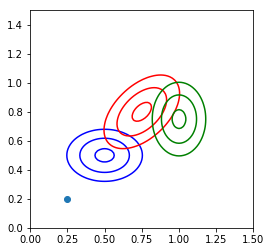

In [2]:
x_p = [0.25, .2]

p_k = np.zeros(K)

for i in range (K):
    p_k[i] = mvn[i].pdf(x_p)
    
print p_k
print "Object ", x_p, " most likely belongs to class ", np.argmax(p_k), "(", colors[np.argmax(p_k)], ")"

pl.clf()
pl.figure(figsize =(4,4))
plotMVN (mvn)
pl.plot([x_p[0]], [x_p[1]], "o")
pl.show()

So we only need to determine $p(C_k|\boldsymbol{x})$

## Logistic Regression

Lets start with a binary classification problem $K = 2$.

<Figure size 432x288 with 0 Axes>

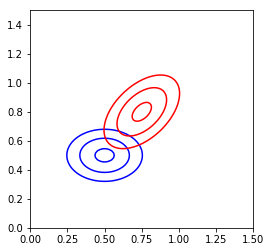

In [3]:
mvn2 = mvn[0:2]

pl.clf()
pl.figure(figsize =(4,4))
plotMVN (mvn2)
pl.show()

Logistic regression adresses the problem of estimating the probability $p(C_1|\boldsymbol{x})$ using a function called the _logistic function_ or _logistic sigmoid_

$p(C_1|\boldsymbol{x}) = y(\boldsymbol{x}) = \sigma (w_0 + w_1x_1 + \cdots + w_mx_m)= \sigma(\boldsymbol{w}^\top\boldsymbol{\phi})$,

where we have defined $\boldsymbol{\phi} = (1, x_1, x_2, \ldots, x_m)$, and 

$\sigma(a) = \frac{1}{1+\exp(-a)} = \frac{\exp(a)}{1 + \exp(a)}$.

The term "sigmoid" means S-shaped.

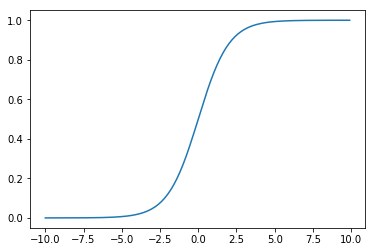

In [4]:
a = np.arange(-10, 10, 0.1)

pl.clf()
pl.plot(a, 1./(1.+np.exp(-a)))
pl.show()

Note that the classic logistic regression model depends on a linear funcion $\boldsymbol{w}^\top\boldsymbol{x} + w_0$.

<Figure size 432x288 with 0 Axes>

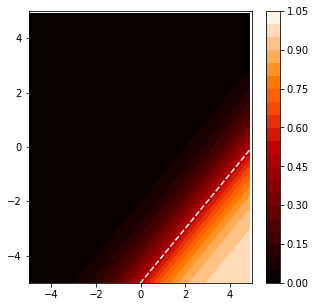

In [5]:
w = [-5, 1, -1]
h = 0.1
pl.clf()
x1_g, x2_g = np.meshgrid(np.arange(-5, 5.0, h),
                         np.arange(-5, 5.0, h))
y = w[0] + w[1]*x1_g + w[2]*x2_g

pl.clf()
pl.figure(figsize =(5,5))
#pl.contourf(x1_g, x2_g, y, cmap=pl.cm.gist_heat, levels = np.arange(-5, 5, 0.1))
pl.contourf(x1_g, x2_g, 1./(1.+np.exp(-y)), cmap=pl.cm.gist_heat, levels = np.arange(0, 1.1, 0.05))
pl.plot([-5, 5], [5*w[1]/w[2] - w[0]/w[2], -5*w[2]/w[1] - w[0]/w[2]], "w--")
pl.xlim([-5,5])
pl.ylim([-5,5])
pl.colorbar()
pl.show()

Notice that 

$\sigma(-a) = 1 - \sigma(a)$.

The inverse of the logistic sigmoid is given by 

$a = \ln\left(\frac{\sigma}{1-\sigma}\right)$

and is knwon as the _logit_ function. Back to our probabilities

$p(C_1|\boldsymbol{x}) = \sigma(\boldsymbol{w}^\top\boldsymbol{\phi})$,

$p(C_2|\boldsymbol{x}) = 1-\sigma(\boldsymbol{w}^\top\boldsymbol{\phi})$.

Hence, 

$\boldsymbol{w}^\top\boldsymbol{\phi} = \ln\left(\frac{p(C_1|\boldsymbol{x})}{p(C_2|\boldsymbol{x})}\right)$,

which is known as the _log odds_. In other words, by using logistic regression we are modeling the log odds by a linear function on $\boldsymbol{x}$.



### Maximum Likelihood Estimation (MLE) for Logistic Regression (LR)

Unlike in linear regression where there exists a closed-form solution to finding the estimates for the true parameters, logistic regression estimates cannot be calculated through simple matrix multiplication. Let's think about the likelihood for LR. 

What distribution defines this type of variable? Given $\boldsymbol{x}$ the probability of being of class $C_1$ is $\sigma(\boldsymbol{w}^\top\boldsymbol{x} + w_0)$. For simplicity, we use a random variable $y \in \{0, 1\}$, where $y = 1$ when the object is of class $C_1$, and $y=0$ when the object is of class $C_2$. This way, we can define

$p(y|\boldsymbol{x}) = \sigma^y(1-\sigma)^{1-y}$,

where we have omitted $\boldsymbol{w}^\top\boldsymbol{\phi}$ to simplify notation. Assuming observations are independent we get the likelihood function

$p(\boldsymbol{y}|\boldsymbol{w}) = \prod_{n = 1}^N \sigma_n^{y_n}(1-\sigma_n)^{1-y_n}$

where $\{(\boldsymbol{x}_n, y_n)\}_{n = 1}^N$ represents the attributes and labels of the observations, and $\sigma_n = \sigma(\boldsymbol{w}^\top\boldsymbol{\phi_n})$. We can define an error function by taking the negative logarithm of the likelihood, which gives the _cross-entropy_ error function in the form

$E(\boldsymbol{w}) = -\ln p(\boldsymbol{y}|\boldsymbol{w}) = -\sum_{n=1}^N \{y_n\ln \sigma_n + (1-y_n)\ln (1-\sigma_n)\}$.

Taking the gradient of the error functionwith respect to $\boldsymbol{w}$, we obtain

$\nabla E(\boldsymbol{w}) = \sum_{n=1}^N(\sigma_n - y_n)\boldsymbol{\phi}$

The factor involving the derivative of the logistic sigmoid has cancelled, leading to a simplified form for the gradient of the log likelihood. The contribution to the gradient from data point $n$ is given by the ‘error’ $\sigma_n − y_n$ between the target value and the prediction of the model, times the basis function vector $\boldsymbol{\phi}$. So how do we determine the parameter estimates? Through an iterative approach (Newton-Raphson). Fortunately, we don't have to implement such procedure thanks to scikit-learn.


<Figure size 432x288 with 0 Axes>

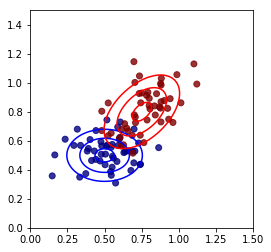

In [6]:
from sklearn import linear_model

# Draw some data from our normal distributions.
N1 = 50
N2 = 50
x2 = np.concatenate ((mvn[0].rvs(N1), mvn[1].rvs(N2)))
y2 = np.zeros(N1 + N2)
y2[:N1] = 1

pl.clf()
pl.figure(figsize=(4,4))
pl.scatter (x2[:, 0], x2[:,1], c = (1-y2), alpha = 0.8, cmap=pl.cm.jet)
plotMVN (mvn2)
pl.show()




<Figure size 432x288 with 0 Axes>

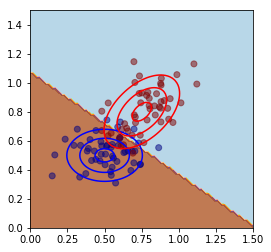

In [7]:
logreg = linear_model.LogisticRegression()
logreg.fit(x2,y2)

y_pred = logreg.predict(np.c_[x1_v.ravel(), x2_v.ravel()])
y_pred = y_pred.reshape((bins, bins))

pl.clf()
pl.figure(figsize=(4,4))
pl.contourf(x1_v, x2_v, y_pred, cmap=pl.cm.Paired, alpha=0.8)
pl.scatter (x2[:, 0], x2[:,1], c = (1-y2), alpha = 0.5, cmap=pl.cm.jet)
plotMVN (mvn2)
pl.show()


### Fixed basis functions

Recall we introduced the vector $\boldsymbol{\phi} = (1, x_1, x_2, \ldots, x_m)$. This is basically working with the original input vector $\boldsymbol{x}$. However, all of the algorithms are equally applicable if we first make a fixed nonlinear transformation of the inputs using a vector of basis functions $\boldsymbol{\phi}(\boldsymbol{x})$. The resulting decision boundaries will be linear in the feature space $\boldsymbol{\phi}$, and these correspond to nonlinear decision boundaries in the original $\boldsymbol{x}$ space.

For example, consider two Gaussian functions $\phi_1(\boldsymbol{x})$ and $\phi_2(\boldsymbol{x})$.


(100,)
(100, 2)


<Figure size 432x288 with 0 Axes>

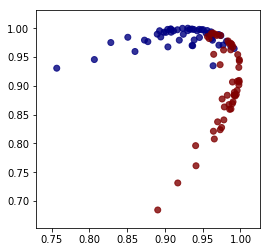

In [8]:
mu1, mu2 = np.array([.75, 0.8]), np.array([.5, 0.5])
s = 1
print (x2-mu1).sum(axis=1).shape
phi = np.array([np.exp(-((x2-mu1)**2).sum(axis=1)/(2*s**2)), 
                np.exp(-((x2-mu2)**2).sum(axis=1)/(2*s**2))]).transpose()
print phi.shape

pl.clf()
pl.figure(figsize=(4,4))
#pl.plot(phi[0], phi[1], "+")
pl.scatter (phi[:, 0], phi[:, 1], c = (1-y2), alpha = 0.8, cmap=pl.cm.jet)
pl.show()

<Figure size 432x288 with 0 Axes>

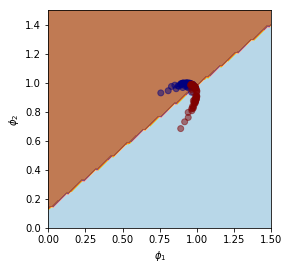

In [9]:
# Now lets use LR

logreg.fit(phi,y2)

y_pred = logreg.predict(np.c_[x1_v.ravel(), x2_v.ravel()])
y_pred = y_pred.reshape((bins, bins))

pl.clf()
pl.figure(figsize=(4,4))
pl.contourf(x1_v, x2_v, y_pred, cmap=pl.cm.Paired, alpha=0.8)
pl.scatter (phi[:, 0], phi[:, 1], c = (1-y2), alpha = 0.5, cmap=pl.cm.jet)
pl.xlabel(r"$\phi_1$")
pl.ylabel(r"$\phi_2$")
pl.show()

<Figure size 432x288 with 0 Axes>

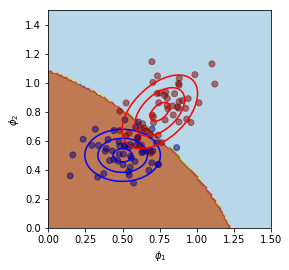

In [10]:
phi_grid = np.array([np.exp(-((np.c_[x1_v.ravel(), x2_v.ravel()]-mu1)**2).sum(axis=1)/(2*s**2)), 
                    np.exp(-((np.c_[x1_v.ravel(), x2_v.ravel()]-mu2)**2).sum(axis=1)/(2*s**2))]).transpose()

y_pred = logreg.predict(phi_grid)
y_pred = y_pred.reshape((bins, bins))

pl.clf()
pl.figure(figsize=(4,4))
pl.contourf(x1_v, x2_v, y_pred, cmap=pl.cm.Paired, alpha=0.8)
pl.scatter (x2[:, 0], x2[:,1], c = (1-y2), alpha = 0.5, cmap=pl.cm.jet)
plotMVN (mvn2)
pl.xlabel(r"$\phi_1$")
pl.ylabel(r"$\phi_2$")
pl.show()

### Regularized Logistic Regression

Recal the negative log-likelihood function we want to optimize

$E(\boldsymbol{w}) = -\ln p(\boldsymbol{y}|\boldsymbol{w}) = -\sum_{n=1}^N \{y_n\ln \sigma_n + (1-y_n)\ln (1-\sigma_n)\}$.

**Occam's razor:** among competing hypotheses explaining the same experiment, the simplest one  should be selected.

A penalty function can be added to the likelihood in order to "encourage" simpler models:

$E(\boldsymbol{w}) = -\sum_{n=1}^N \{y_n\ln \sigma_n + (1-y_n)\ln (1-\sigma_n)\} + \lambda^2\left(||\boldsymbol{w}||_p\right)^p$,

where $||\boldsymbol{w}||_p = \left(\sum_{j=1}^M |w_i|^p\right)^{1/p}$. For example, for $p = 1$

$E(\boldsymbol{w}) = -\sum_{n=1}^N \{y_n\ln \sigma_n + (1-y_n)\ln (1-\sigma_n)\} + \lambda^2\sum_{j=1}^M |w_j|$,

which is called a L1 regularized logistic regression. For $p = 2$

$E(\boldsymbol{w}) = -\sum_{n=1}^N \{y_n\ln \sigma_n + (1-y_n)\ln (1-\sigma_n)\} + \lambda^2\sum_{j=1}^M w_j^2$,

and we call it a L2 regularized logistic regression.

The result is just like in linear regression: shrinkage towards zero of the parameters.

In practice, the intercept is usually not part of the penalty factor, and is thus not shrunk towards zero.

In scikit-learn regularization is controlled by a $C$ constant equivalent to $1/\lambda^2$.

<Figure size 432x288 with 0 Axes>

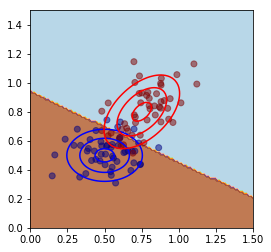

In [11]:
logreg = linear_model.LogisticRegression(C = 1e5)
logreg.fit(x2,y2)

y_pred = logreg.predict(np.c_[x1_v.ravel(), x2_v.ravel()])
y_pred = y_pred.reshape((bins, bins))

pl.clf()
pl.figure(figsize=(4,4))
pl.contourf(x1_v, x2_v, y_pred, cmap=pl.cm.Paired, alpha=0.8)
pl.scatter (x2[:, 0], x2[:,1], c = (1-y2), alpha = 0.5, cmap=pl.cm.jet)
plotMVN (mvn2)
pl.show()


How do we choose $C$? Through cross validation.

### Multiclass logistic regression

How do we use LR for more than two classes? There are several extensions to standard logistic regression when the response variable Y has more than 2 categories. 

Recal our original distributions

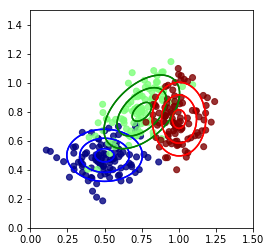

In [14]:
x3 = np.concatenate ((x[0], x[1], x[2]))
y3 = np.zeros(3*N)
y3[N:2*N] = 1
y3[2*N:] = 2

pl.clf()
pl.figure(figsize =(4,4))
colors = ["blue", "green", "red"]
plotMVN (mvn)
pl.scatter (x3[:, 0], x3[:,1], c = (y3), alpha = 0.8, cmap=pl.cm.jet)
plotMVN (mvn)
pl.show()

The default multiclass logistic regression model is called the ’One vs. Rest’ (OvR) approach.
If there are 3 classes, then 3 separate logistic regression are fit, where the probability of each category is predicted over the rest of the categories combined.In our case, we would need to train 3 models:
1. $C_1$ from $C_2$ and $C_3$ combined
2. $C_2$ from $C_1$ and $C_3$ combined
3. $C_3$ from $C_2$ and $C_1$ combined

Scikit-learn has this implemented.

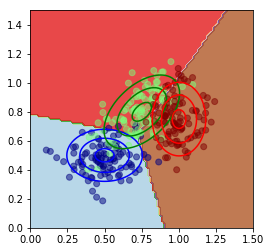

In [19]:
logreg = linear_model.LogisticRegression(C = 1)
logreg.fit(x3,y3)

y_pred = logreg.predict(np.c_[x1_v.ravel(), x2_v.ravel()])
y_pred = y_pred.reshape((bins, bins))

pl.clf()
pl.figure(figsize=(4,4))
pl.contourf(x1_v, x2_v, y_pred, cmap=pl.cm.Paired, alpha=0.8)
pl.scatter (x3[:, 0], x3[:,1], c = (y3), alpha = 0.5, cmap=pl.cm.jet)
plotMVN (mvn)
pl.show()

## Discriminant Analysis

Consider a Bayesian approach in which we model the class-conditional densities $p(\boldsymbol{x}|C_k)$, as well as the class priors $p(C_k)$, and then use these to compute posterior probabilities $p(C_k|\boldsymbol{x})$ through Bayes’ theorem.

Consider first of all the case of two classes. The posterior probability for class $C_1$ can be written as

$p(C_1|\boldsymbol{x}) = \frac{p(\boldsymbol{x}|C_1)p(C_1)}{p(\boldsymbol{x}|C_1)p(C_1) + p(\boldsymbol{x}|C_2)p(C_2)}$

$= \frac{1}{1+\exp(-a)} = \sigma(a)$,

where we have defined

$a = \ln \frac{p(\boldsymbol{x}|C_1)p(C_1)}{p(\boldsymbol{x}|C_2)p(C_2)}$

For the case of more than two classes this can be written as

$p(C_k|\boldsymbol{x}) = \frac{p(\boldsymbol{x}|C_k)p(C_k)}{\sum_jp(\boldsymbol{x}|C_j)p(C_j)}$

$= \frac{\exp(a_k)}{\sum_j \exp(a_j)}$.

which is known as the normalized exponential and can be regarded as a multiclass generalization of the logistic sigmoid, and

$a_k = \ln (p(\boldsymbol{x}|C_k)p(C_k))$

## Linear Discriminant Analysis

Now, let us assume that the class-conditional densities are Gaussian and then explore the resulting form for the posterior probabilities. To start with, we shall assume that all classes share the same covariance matrix. Thus the density for class $C_k$ is given by

$p(\boldsymbol{x|C_k}) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{D/2}}\frac{1}{|\boldsymbol{\Sigma}|^{1/2}}\exp({-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu}_k)^\top\boldsymbol{\Sigma}(\boldsymbol{x}-\boldsymbol{\mu}_k)})$.

First consider the case of two classes, so we have

$p(C_1|\boldsymbol{x}) = \sigma(\boldsymbol{w}^\top\boldsymbol{x} + w_0)$, where

$\boldsymbol{w} = \boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu}_1 - \boldsymbol{\mu}_2)$

$w_0 = -\frac{1}{2}\boldsymbol{\mu}_1^\top\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_1 + \frac{1}{2}\boldsymbol{\mu}_2^\top\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_2 + \ln\left(\frac{p(C_1)}{p(C_2)}\right)$

We see that the quadratic terms in $\boldsymbol{x}$ from the exponents of the Gaussian densities have cancelled (due to the assumption of common covariance matrices) leading to a linear function of $\boldsymbol{x}$ in the argument of the logistic sigmoid. 


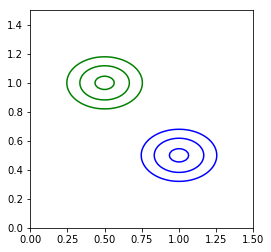

In [25]:
mu_d = np.array([[1., 0.5],
              [0.5, 1.]])
S_d = np.array([[[0.02, 0],
             [0, 0.01]],
             [[0.02, 0],
             [0, 0.01]]])
mvn_d = []
for i in range(mu_d.shape[0]):
    mvn_d.append(multivariate_normal(mean=mu_d[i], cov=S_d[i]))

pl.clf()
pl.figure(figsize =(4,4))
colors = ["blue", "green", "red"]
plotMVN (mvn_d)
pl.show()


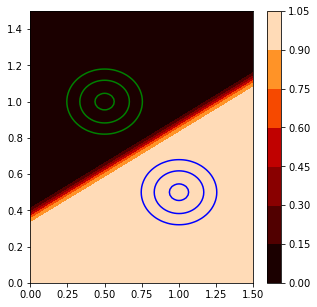

In [26]:
x_dg = np.c_[x1_v.ravel(), x2_v.ravel()]
P_1 = 0.5
P_2 = 1 - P_1
P_x_1 = mvn_d[0].pdf(x_dg)*P_1/(mvn_d[0].pdf(x_dg)*P_1 + mvn_d[1].pdf(x_dg)*P_2)
    
P_x_1g = P_x_1.reshape((bins, bins))

pl.clf()
pl.figure(figsize =(5,5))
pl.contourf(x1_v, x2_v, P_x_1g, cmap=pl.cm.gist_heat)
pl.colorbar()
plotMVN (mvn_d)
pl.show()

Recall for the general case of $K$ classes

$p(C_k|\boldsymbol{x}) = \frac{\exp(a_k)}{\sum_j \exp(a_j)}$.

$a_k(\boldsymbol{x}) = \ln (p(\boldsymbol{x}|C_k)p(C_k))$

$a_k(\boldsymbol{x}) = \boldsymbol{w}_k^\top \boldsymbol{x}+w_{k0}$

where we have defined

$\boldsymbol{w} = \boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_k$

$w_0 = -\frac{1}{2}\boldsymbol{\mu}_k^\top\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_k  + \ln p(C_k)$

We see that the $a_k(\boldsymbol{x})$ are again linear functions of $\boldsymbol{x}$ as a consequence of the cancellation of the quadratic terms due to the shared covariances. The resulting decision boundaries, corresponding to the minimum misclassification rate, will occur when two of the posterior probabilities (the two largest) are equal, and so will be defined by linear functions of $\boldsymbol{x}$, and so again we have a generalized linear model.

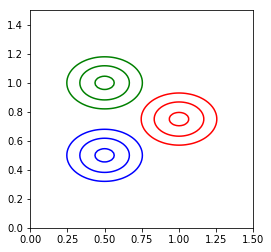

In [27]:
mu_d = np.array([[0.5, 0.5],
                 [0.5, 1.],
                 [1., 0.75]])
S_d = np.array([[[0.02, 0],
             [0, 0.01]],
             [[0.02, 0],
             [0, 0.01]],
             [[0.02, 0],
             [0, 0.01]]])
mvn_d = []
for i in range(mu_d.shape[0]):
    mvn_d.append(multivariate_normal(mean=mu_d[i], cov=S_d[i]))

pl.clf()
pl.figure(figsize =(4,4))
colors = ["blue", "green", "red"]
plotMVN (mvn_d)
pl.show()

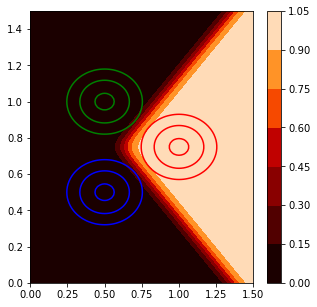

In [31]:
x_dg = np.c_[x1_v.ravel(), x2_v.ravel()]
P_1 = 0.3
P_2 = 0.3
P_3 = 1 - P_1 -P_2
Z =(mvn_d[0].pdf(x_dg)*P_1 + mvn_d[1].pdf(x_dg)*P_2 + mvn_d[2].pdf(x_dg)*P_3)

P_x_1 = mvn_d[2].pdf(x_dg)*P_3/Z

P_x_1g = P_x_1.reshape((bins, bins))

pl.clf()
pl.figure(figsize =(5,5))
pl.contourf(x1_v, x2_v, P_x_1g, cmap=pl.cm.gist_heat)
pl.colorbar()
plotMVN (mvn_d)
pl.show()

### Quadratic Discriminat Analysis

If we relax the assumption of a shared covariance matrix and allow each class-conditional density $p(\boldsymbol{x}|C_k)$ to have its own covariance matrix $\boldsymbol{\Sigma}_k$, then the earlier cancellations will no longer occur, and we will obtain quadratic functions of $\boldsymbol{x}$, giving rise to a _quadratic discriminant_.

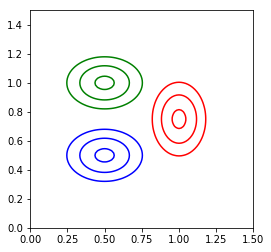

In [32]:
mu_d = np.array([[0.5, 0.5],
                 [0.5, 1.],
                 [1., 0.75]])
S_d = np.array([[[0.02, 0],
             [0, 0.01]],
             [[0.02, 0],
             [0, 0.01]],
             [[0.01, 0],
             [0, 0.02]]])
mvn_d = []
for i in range(mu_d.shape[0]):
    mvn_d.append(multivariate_normal(mean=mu_d[i], cov=S_d[i]))

pl.clf()
pl.figure(figsize =(4,4))
colors = ["blue", "green", "red"]
plotMVN (mvn_d)
pl.show()

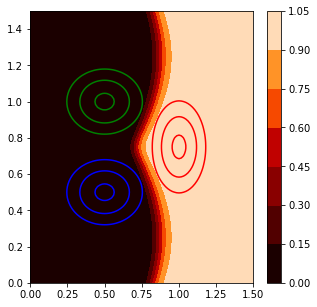

In [35]:
x_dg = np.c_[x1_v.ravel(), x2_v.ravel()]
P_1 = 0.3
P_2 = 0.3
P_3 = 1 - P_1 -P_2
Z =(mvn_d[0].pdf(x_dg)*P_1 + mvn_d[1].pdf(x_dg)*P_2 + mvn_d[2].pdf(x_dg)*P_3)

P_x_1 = mvn_d[2].pdf(x_dg)*P_3/Z

P_x_1g = P_x_1.reshape((bins, bins))

pl.clf()
pl.figure(figsize =(5,5))
pl.contourf(x1_v, x2_v, P_x_1g, cmap=pl.cm.gist_heat)
pl.colorbar()
plotMVN (mvn_d)
pl.show()

## Logistic Regression versus Discriminant Analysis

We'll compare our lineal models using a couple of data sets.

In [37]:
from time import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_score

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lr  = linear_model.LogisticRegression(C = 1e10)

def compare(x, y, k_fold = 10):
    t = time()
    sc = cross_val_score(lr, x, y, cv=k_fold)*100
    t = time()-t
    print "LR: score = ", np.mean(sc), " +- ", np.std(sc), ", time = ", t

    t = time()
    sc = cross_val_score(lda, x, y, cv=k_fold)*100
    t = time()-t
    print "LDA: score = ", np.mean(sc), " +- ", np.std(sc), ", time = ", t
    
    t = time()
    sc = cross_val_score(qda, x, y, cv=k_fold)*100
    t = time()-t
    print "QDA: score = ", np.mean(sc), " +- ", np.std(sc), ", time = ", t   

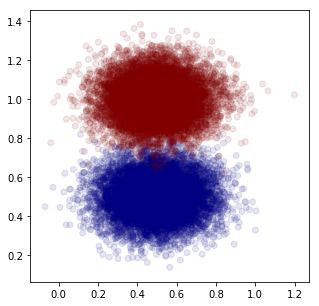

LR: score =  99.365  +-  0.207424685127 , time =  0.336313009262
LDA: score =  99.355  +-  0.204266982158 , time =  0.129324197769
QDA: score =  99.33  +-  0.219317121995 , time =  0.134418964386


In [38]:
mu_d = np.array([[0.5, 0.5],
              [0.5, 1.]])
S_d = np.array([[[0.02, 0],
             [0, 0.01]],
             [[0.02, 0],
             [0, 0.01]]])
Ns = [10000, 10000]
mvn_d = []
x = np.array([]).reshape((0, 2))
y = []
for i in range(mu_d.shape[0]):
    mvn_d.append(multivariate_normal(mean=mu_d[i], cov=S_d[i]))
    x = np.concatenate((x, mvn_d[i].rvs(Ns[i])))
    y = y + [i]*Ns[i]

pl.clf()
pl.figure(figsize = (5,5))
pl.scatter(x[:, 0], x[:, 1], c= y, alpha = 0.1, cmap=pl.cm.jet)
pl.show()

compare(x, y)


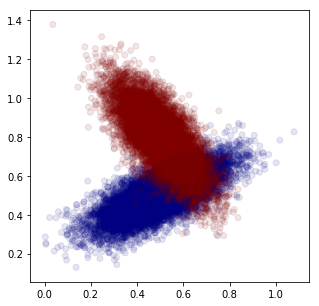

LR: score =  89.76  +-  0.893532316148 , time =  0.300614118576
LDA: score =  89.34  +-  0.881419309977 , time =  0.129146814346
QDA: score =  91.79  +-  0.586003412959 , time =  0.116376161575


In [40]:
mu_d = np.array([[0.5, 0.5],
              [0.5, .8]])
S_d = np.array([[[0.02, 0.01],
             [0.01, 0.01]],
             [[0.01, -0.01],
             [-0.01, 0.02]]])
Ns = [10000, 10000]
mvn_d = []
x = np.array([]).reshape((0, 2))
y = []
for i in range(mu_d.shape[0]):
    mvn_d.append(multivariate_normal(mean=mu_d[i], cov=S_d[i]))
    x = np.concatenate((x, mvn_d[i].rvs(Ns[i])))
    y = y + [i]*Ns[i]

pl.clf()
pl.figure(figsize = (5,5))
pl.scatter(x[:, 0], x[:, 1], c= y, alpha = 0.1, cmap=pl.cm.jet)
pl.show()

compare(x, y)

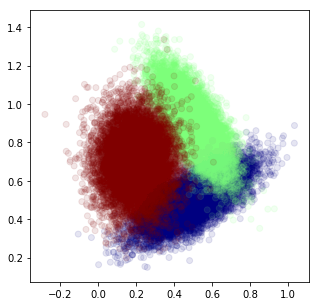

LR: score =  93.1233333333  +-  0.331344064213 , time =  1.05539512634
LDA: score =  92.28  +-  0.400887903423 , time =  0.219727039337
QDA: score =  94.22  +-  0.420105806778 , time =  0.222805976868


In [41]:
mu_d = np.array([[0.5, 0.5],
                [0.5, .9],
                [0.2, 0.7]])
S_d = np.array([[[0.02, 0.01],
             [0.01, 0.01]],
             [[0.01, -0.01],
             [-0.01, 0.02]],
             [[0.01, 0.0],
             [0.0, 0.02]]])
Ns = [10000, 10000, 10000]
mvn_d = []
x = np.array([]).reshape((0, 2))
y = []
for i in range(mu_d.shape[0]):
    mvn_d.append(multivariate_normal(mean=mu_d[i], cov=S_d[i]))
    x = np.concatenate((x, mvn_d[i].rvs(Ns[i])))
    y = y + [i]*Ns[i]

pl.clf()
pl.figure(figsize = (5,5))
pl.scatter(x[:, 0], x[:, 1], c= y, alpha = 0.1, cmap=pl.cm.jet)
pl.show()

compare(x, y)

### A more realistic problem: the iris data-set

* The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.
* Attributes are: 
 * sepal length in cm
 * sepal width in cm
 * petal length in cm
 * petal width in cm
 
* Classes are:
 * Iris-Setosa
 * Iris-Versicolour
 * Iris-Virginica


<img src =http://nook.cs.ucdavis.edu/~koehl/Teaching/BL5229/Labs/Images/iris.png>

(150, 4)


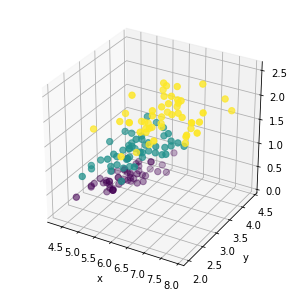

In [46]:
from sklearn.datasets import load_iris
from mpl_toolkits.mplot3d import Axes3D

iris = load_iris()
x = iris.data
y = iris.target
print x.shape

pl.clf()
fig = pl.figure(figsize = (5, 5))
ax = fig.gca(projection='3d')

ax.scatter(x[:, 0], x[:, 1], x[:, 3], c = y, s = 40)
pl.xlabel("x")
pl.ylabel("y")

pl.show()

In [48]:
compare(x,y, k_fold = 50)

LR: score =  96.0  +-  12.7191893522 , time =  0.199066877365
LDA: score =  98.0  +-  10.3494497975 , time =  0.143231153488
QDA: score =  97.3333333333  +-  11.2348663642 , time =  0.135513067245


### Digits data-set
<img src =https://d3ansictanv2wj.cloudfront.net/05.02-Introducing-Scikit-Learn_64_0-19d4c9077e5dae863b5370386bf0779f.png>

In [49]:
from sklearn.datasets import load_digits

digits = load_digits()
x = digits.data
y = digits.target
print x.shape, np.unique(y)

compare(x,y, k_fold = 10)

(1797, 64) [0 1 2 3 4 5 6 7 8 9]
LR: score =  90.7131064293  +-  3.35386523792 , time =  10.9513969421
LDA: score =  91.9817748152  +-  2.82586538809 , time =  0.111027956009


/Users/guille/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/guille/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA: score =  82.8365591143  +-  3.54068468628 , time =  0.223994016647


### Breast Cancer

In [50]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
x = bc.data
y = bc.target
print x.shape, np.unique(y)

compare(x,y, k_fold = 10)

(569, 30) [0 1]
LR: score =  95.4286578515  +-  1.79989075774 , time =  0.165197134018
LDA: score =  95.6226773831  +-  2.61702155138 , time =  0.0402331352234
QDA: score =  95.5980468412  +-  2.12978213952 , time =  0.0494410991669


### Random noise

(2000, 2) 2000


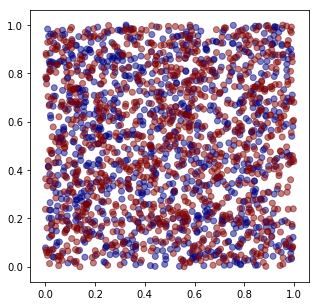

LR: score =  50.3  +-  2.69443871706 , time =  0.0542860031128
LDA: score =  50.3  +-  2.69443871706 , time =  0.0393750667572
QDA: score =  49.8  +-  3.66196668472 , time =  0.031270980835


In [52]:
N1, N2 = 1000, 1000
x = np.array([np.random.random(N1+N2), np.random.random(N1+N2)]).transpose()
y = [0]*N1 + [1]*N2
print x.shape, len(y)

pl.clf()
pl.figure(figsize = (5,5))
pl.scatter(x[:, 0], x[:, 1], c= y, alpha = 0.5, cmap=pl.cm.jet)
pl.show()

compare(x,y, k_fold = 10)